# What opportunities exist for using LLMs in personalized email marketing campaigns?

## 1. Create an LLM-powered system for generating personalized email content based on customer data and preferences.


In [1]:
import pandas as pd
import os
import nltk
import numpy as np
from h2ogpte import H2OGPTE
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from IPython.display import Markdown


In [2]:
#load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

In [3]:
# Connect to postgres
engine = create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [4]:
# Importing Data
online_sales = pd.read_sql("SELECT * FROM online_sales", engine)
products = pd.read_sql("SELECT * FROM products", engine)
users = pd.read_sql("SELECT * FROM users", engine)

In [5]:
# Viewing Datasets
online_sales

,cust_id,transaction_id,date,product_id,delivery_charges,coupon_status,coupon_code,discount_percentage,quantity
0,12346,38223,2019-09-15,B0B2RBP83P,75.00,Used,OFF30,0.3,2
1,12346,38223,2019-09-15,B0B6F7LX4C,75.00,Used,SALE30,0.3,1
2,12347,23979,2019-03-24,B00LZLQ624,14.41,Used,OFF30,0.3,1
3,12347,23979,2019-03-24,B095X38CJS,14.41,Not Used,OFF30,0.3,1
4,12347,23980,2019-03-24,B00Y4ORQ46,6.50,Not Used,ELEC30,0.3,5
...,...,...,...,...,...,...,...,...,...
50452,18283,40289,2019-10-10,B0B9XLX8VR,6.50,Used,SALE10,0.1,1
50453,18283,40290,2019-10-10,B07LFWP97N,6.00,Used,SALE10,0.1,1
50454,18283,40290,2019-10-10,B07Z1X6VFC,6.00,Used,SALE10,0.1,2
50455,18283,40291,2019-10-10,B01JOFKL0A,26.43,Not Used,SALE10,0.1,1


In [6]:
# Viewing Datasets
products.drop(['discounted_price', 'discount_percentage'], axis=1, inplace=True)
products

,product_id,product_name,about_product,category,actual_price,origin_area,img_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Computers&Accessories|Accessories&Peripherals|...,13.19,None,https://m.media-amazon.com/images/W/WEBP_40237...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Computers&Accessories|Accessories&Peripherals|...,4.19,None,https://m.media-amazon.com/images/W/WEBP_40237...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Computers&Accessories|Accessories&Peripherals|...,22.79,None,https://m.media-amazon.com/images/W/WEBP_40237...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,The boAt Deuce USB 300 2 in 1 cable is compati...,Computers&Accessories|Accessories&Peripherals|...,8.39,None,https://m.media-amazon.com/images/I/41V5FtEWPk...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Computers&Accessories|Accessories&Peripherals|...,4.79,None,https://m.media-amazon.com/images/W/WEBP_40237...
...,...,...,...,...,...,...,...
1346,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,11.03,None,https://m.media-amazon.com/images/I/41fDdRtjfx...
1347,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,"230 Volts, 400 watts, 1 Year",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,36.54,None,https://m.media-amazon.com/images/I/41gzDxk4+k...
1348,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,International design and styling|Two heat sett...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",36.96,None,https://m.media-amazon.com/images/W/WEBP_40237...
1349,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,Fan sweep area: 230 MM ; Noise level: (40 - 45...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",22.68,None,https://m.media-amazon.com/images/W/WEBP_40237...


In [7]:
# Viewing Datasets
users

,user_id,age,gender
0,1,23,Female
1,2,23,Female
2,3,24,Prefer not to say
3,4,24,Female
4,5,22,Female
...,...,...,...
2065,14438,57,Female
2066,12956,60,Female
2067,15781,55,Male
2068,14410,19,Female


In [8]:
# Merge data
df = pd.merge(online_sales, products, on='product_id', how='left')
df

,cust_id,transaction_id,date,product_id,delivery_charges,coupon_status,coupon_code,discount_percentage,quantity,product_name,about_product,category,actual_price,origin_area,img_link
0,12346,38223,2019-09-15,B0B2RBP83P,75.00,Used,OFF30,0.3,2,"Lenovo IdeaPad 3 11th Gen Intel Core i3 15.6"" ...",Processor: 11th Gen Intel Core i3-1115G4 | Spe...,Computers&Accessories|Laptops|TraditionalLaptops,718.68,None,https://m.media-amazon.com/images/I/41PnIUzyYM...
1,12346,38223,2019-09-15,B0B6F7LX4C,75.00,Used,SALE30,0.3,1,MI 80 cm (32 inches) 5A Series HD Ready Smart ...,"Note : The brands, Mi and Xiaomi, are part of ...","Electronics|HomeTheater,TV&Video|Televisions|S...",299.99,None,https://m.media-amazon.com/images/I/51fmHk3km+...
2,12347,23979,2019-03-24,B00LZLQ624,14.41,Used,OFF30,0.3,1,Classmate Soft Cover 6 Subject Spiral Binding ...,The cover design of the notebook is subject to...,OfficeProducts|OfficePaperProducts|Paper|Stati...,1.92,None,https://m.media-amazon.com/images/I/419KXo-7kD...
3,12347,23979,2019-03-24,B095X38CJS,14.41,Not Used,OFF30,0.3,1,BRUSTRO Copytinta Coloured Craft Paper A4 Size...,Made at the renowned Fabriano paper mill in It...,OfficeProducts|OfficePaperProducts|Paper|Copy&...,1.19,None,https://m.media-amazon.com/images/I/41WggyozHQ...
4,12347,23980,2019-03-24,B00Y4ORQ46,6.50,Not Used,ELEC30,0.3,5,Logitech H111 Wired On Ear Headphones With Mic...,ADJUSTABLE HEADBAND This sturdy yet lightweigh...,"Electronics|Headphones,Earbuds&Accessories|Hea...",9.54,None,https://m.media-amazon.com/images/W/WEBP_40237...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50452,18283,40289,2019-10-10,B0B9XLX8VR,6.50,Used,SALE10,0.1,1,VU 139 cm (55 inches) The GloLED Series 4K Sma...,Resolution: 4K Ultra HD (3840x2160) | Refresh ...,"Electronics|HomeTheater,TV&Video|Televisions|S...",780.00,None,https://m.media-amazon.com/images/I/41pdZIhY+g...
50453,18283,40290,2019-10-10,B07LFWP97N,6.00,Used,SALE10,0.1,1,Gizga Essentials Laptop Bag Sleeve Case Cover ...,Innovative Design: This Laptop Case is made of...,Computers&Accessories|Accessories&Peripherals|...,13.19,None,https://m.media-amazon.com/images/W/WEBP_40237...
50454,18283,40290,2019-10-10,B07Z1X6VFC,6.00,Used,SALE10,0.1,2,AirCase Protective Laptop Bag Sleeve fits Upto...,Innovative Design: This Laptop Case is made of...,Computers&Accessories|Accessories&Peripherals|...,11.99,None,https://m.media-amazon.com/images/I/41GogihEYe...
50455,18283,40291,2019-10-10,B01JOFKL0A,26.43,Not Used,SALE10,0.1,1,Canon PIXMA E477 All-in-One Wireless Ink Effic...,Printer type: Ink Efficient; Functionality All...,"Computers&Accessories|Printers,Inks&Accessorie...",76.26,None,https://m.media-amazon.com/images/I/31ejgWaEay...


### User Based Collaborative Filtering

User-Based Collaborative Filtering provides personalized recommendations by leveraging similarities between users' purchasing behaviors computed based on cosine similarity between users, making it intuitive and easy to implement without relying on product metadata. This approach fosters tailored user experiences and can uncover serendipitous product discoveries. However, UBCF faces challenges such as scalability issues with large user bases, data sparsity that can limit the effectiveness of similarity measures, and the cold start problem where new users or products lack sufficient interaction data. Additionally, it may suffer from popularity bias, leading to less diverse recommendations. Balancing these strengths and limitations is key to optimizing UBCF for an effective e-commerce recommendation system.

In [9]:
def user_based_recommendation(cust_id, df, top_n=5):
    """
    Recommend top N products for a given user based on user similarity.

    Parameters:
    - cust_id (int): The ID of the user for whom to generate recommendations.
    - df (DataFrame): The preprocessed DataFrame containing user transactions.
    - top_n (int): Number of top recommendations to return.

    Returns:
    - recommendations (list): List of recommended product IDs.
    """

    # Check if the cust_id exists in the DataFrame
    if cust_id not in df['cust_id'].unique():
        print(f"User ID {cust_id} not found in the dataset.")
        return []

    # 1. Create the User-Item Matrix
    user_item_matrix = df.pivot_table(index='cust_id',
                                      columns='product_id',
                                      values='quantity',
                                      aggfunc='sum',
                                      fill_value=0)

    # 2. Compute User Similarity Matrix using Cosine Similarity
    # Cosine similarity returns values between 0 and 1
    similarity_matrix = cosine_similarity(user_item_matrix)
    
    # Convert the similarity matrix to a DataFrame for easier handling
    similarity_df = pd.DataFrame(similarity_matrix, 
                                 index=user_item_matrix.index, 
                                 columns=user_item_matrix.index)

    # 3. Find Similar Users
    # Get similarity scores for the target user
    user_similarities = similarity_df[cust_id].sort_values(ascending=False)
    
    # Exclude the target user from the similarity scores
    user_similarities = user_similarities.drop(labels=[cust_id])

    # Select top similar users (you can adjust the number, e.g., top 10)
    top_similar_users = user_similarities.head(10).index.tolist()

    if not top_similar_users:
        print(f"No similar users found for User ID {cust_id}.")
        return []

    # 4. Aggregate Products from Similar Users
    # Select the purchase data of similar users
    similar_users_data = df[df['cust_id'].isin(top_similar_users)]

    # Aggregate the quantities for each product from similar users
    product_scores = similar_users_data.groupby('product_id')['quantity'].sum()

    # 5. Exclude Products Already Purchased by the Target User
    # Get the list of products already purchased by the target user
    user_purchased_products = df[df['cust_id'] == cust_id]['product_id'].unique()

    # Remove these products from the recommendation candidates
    product_scores = product_scores.drop(labels=user_purchased_products, errors='ignore')

    if product_scores.empty:
        print(f"No new products to recommend for User ID {cust_id}.")
        return []

    # 6. Sort the products based on the aggregated scores in descending order
    sorted_products = product_scores.sort_values(ascending=False)

    # 7. Select the Top N Products
    recommended_products = sorted_products.head(top_n).index.tolist()

    # Print the recommended products with their names
    recommended_product_names = products[products['product_id'].isin(recommended_products)]['product_name'].tolist()

    return recommended_products, recommended_product_names

In [10]:
# Testing the Function
user_based_recommendation(12583, df, top_n=5)

(['B078KRFWQB', 'B07LFWP97N', 'B07VX71FZP', 'B078W65FJ7', 'B0B61HYR92'],
 ['Lapster usb 2.0 mantra cable, mantra mfs 100 data cable (black)',
  'Gizga Essentials Laptop Bag Sleeve Case Cover Pouch with Handle for 14.1 Inch Laptop for Men & Women, Padded Laptop Compartment, Premium Zipper Closure, Water Repellent Nylon Fabric, Grey',
  'boAt BassHeads 900 On-Ear Wired Headphones with Mic (White)',
  'Amazon Brand - Solimo 2000/1000 Watts Room Heater with Adjustable Thermostat (ISI certified, White colour, Ideal for small to medium room/area)',
  'Havells Cista Room Heater, White, 2000 Watts'])

### Content Based Reccomendation

The function aims to generate personalized product recommendations for a user by analyzing the content (attributes) of products they have previously purchased. It uses a content-based filtering approach, which relies on the similarity between product attributes to suggest new products that are similar to those the user has already bought.

To encourage upselling, higher prices item are reccomended back to the user.

In [11]:
# Define a function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    # Tokenize, remove stop words, and apply stemming
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words]
    
    return ' '.join(tokens)

def content_based_recommendation(cust_id, transactions_df, products_df, top_n=5):
    """
    Recommend top N products for a given user based on content similarity.
    
    Parameters:
    - cust_id (int): The ID of the user for whom to generate recommendations.
    - transactions_df (DataFrame): The DataFrame containing user transactions.
    - products_df (DataFrame): The DataFrame containing product details.
    - top_n (int): Number of top recommendations to return.
    
    Returns:
    - recommendations (list): List of recommended product IDs.
    """
    
    # Check if the cust_id exists in the transactions DataFrame
    if cust_id not in transactions_df['cust_id'].unique():
        print(f"User ID {cust_id} not found in the dataset.")
        return []

    # 1. Create a new feature by combining relevant product attributes in the products DataFrame
    products_df['combined_features'] = products_df['product_name'] + ' ' + products_df['about_product'] + ' ' + products_df['category']
    
    # 2. Apply text preprocessing to the combined features
    products_df['combined_features'] = products_df['combined_features'].apply(preprocess_text)
    
    # 3. Remove duplicate products to ensure each product is unique
    products_df = products_df[['product_id', 'combined_features','actual_price']].drop_duplicates().reset_index(drop=True)
    
    # 4. Initialize the TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    
    # 5. Fit and transform the combined features
    tfidf_matrix = tfidf.fit_transform(products_df['combined_features'])
    
    # 6. Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # 7. Create a reverse mapping of product indices and IDs
    indices = pd.Series(products_df.index, index=products_df['product_id']).drop_duplicates()
    
    # 8. Get the list of products purchased by the user from the transactions DataFrame
    user_purchases = transactions_df[transactions_df['cust_id'] == cust_id]['product_id'].unique()
    
    # 9. Initialize a series to hold similarity scores
    similarity_scores = pd.Series(dtype=float)
    
    # 10. Iterate over each purchased product and accumulate similarity scores
    for product_id in user_purchases:
        if product_id not in indices:
            continue  # Skip if the product_id is not in the dataset
        idx = indices[product_id]
        sim_scores = pd.Series(cosine_sim[idx]).sort_values(ascending=False)
        sim_scores = sim_scores.iloc[1:]  # Exclude the product itself
        similarity_scores = similarity_scores.add(sim_scores, fill_value=0)
    
    if similarity_scores.empty:
        print(f"No similar products found for User ID {cust_id}.")
        return []
    
    # 11. Remove products already purchased by the user
    similarity_scores = similarity_scores.drop(labels=[indices[pid] for pid in user_purchases if pid in indices], errors='ignore')
    
    if similarity_scores.empty:
        print(f"No new products to recommend for User ID {cust_id}.")
        return []
    
    # 12. Sort the products based on similarity scores and price (for upselling)
    similarity_scores = similarity_scores.sort_values(ascending=False)
    top_indices = similarity_scores.head(top_n * 2).index.tolist()  # Get more candidates
    
    # 13. Map indices back to product IDs and filter by price
    recommended_products = products_df.iloc[top_indices]
    recommended_products = recommended_products.sort_values(by='actual_price', ascending=False)  # Prioritize higher-priced items
    recommended_product_ids = recommended_products.head(top_n)['product_id'].tolist()
    
    return recommended_product_ids

In [12]:
# Testing the Function
content_based_recommendation(12583, df, products, top_n=5)

['B0BC8BQ432', 'B095JQVC7N', 'B0B997FBZT', 'B0B1YZ9CB8', 'B0B1YZX72F']

### Coldstart Reccomendation

The cold_start_recommendation function provides a practical solution for recommending products to new users by leveraging the popularity of products. This approach ensures that new users receive relevant and popular product recommendations, even without prior interaction data.

In [13]:
def popularity_based_recommendation(transactions_df, products_df, top_n=5, category=None):
    """
    Recommend top N popular products based on overall sales or within a specific category.
    
    Parameters:
    - transactions_df (DataFrame): DataFrame containing user transactions with columns ['cust_id', 'product_id', 'quantity', ...].
    - products_df (DataFrame): DataFrame containing product details with columns ['product_id', 'product_name', 'about_product', 'category', ...].
    - top_n (int): Number of top recommendations to return.
    - category (str, optional): If specified, recommend popular products within this category.
    
    Returns:
    - recommended_product_ids (list): List of recommended product IDs.
    """
    
    # Merge transactions with products to get category information
    merged_df = transactions_df.merge(products_df, on='product_id', how='left')
    
    # If category is specified, filter by category
    if category:
        merged_df = merged_df[merged_df['category'] == category]
    
    # Aggregate the total quantity sold for each product
    product_sales = merged_df.groupby('product_id')['quantity'].sum().sort_values(ascending=False)
    
    # Get the top N product IDs
    recommended_product_ids = product_sales.head(top_n).index.tolist()
    
    return recommended_product_ids

def cold_start_recommendation(cust_id, transactions_df, products_df, users_df=None, top_n=5):
    """
    Recommend top N products for a new user using a hybrid approach combining popularity and demographic-based recommendations.
    
    Parameters:
    - cust_id (int): The ID of the user for whom to generate recommendations.
    - transactions_df (DataFrame): DataFrame containing user transactions with columns ['cust_id', 'product_id', 'quantity', ...].
    - products_df (DataFrame): DataFrame containing product details with columns ['product_id', 'product_name', 'about_product', 'category', ...].
    - users_df (DataFrame, optional): DataFrame containing user demographic details with columns ['cust_id', 'age', 'gender', 'location', ...].
    - top_n (int): Number of top recommendations to return.
    
    Returns:
    - recommended_product_ids (list): List of recommended product IDs.
    """
    
    # Check if the user exists in the transactions (i.e., is not a new user)
    if cust_id in transactions_df['cust_id'].unique():
        print(f"User ID {cust_id} exists in the dataset. Use user-based or content-based recommendations instead.")
        return []
    
    # Initialize a dictionary to hold recommendation scores
    rec_scores = {}
    
    popular_recs = popularity_based_recommendation(transactions_df, products_df, top_n=top_n*2)
    for pid in popular_recs:
        rec_scores[pid] = rec_scores.get(pid, 0) + 1  # Weight can be adjusted as needed

    # Sort the products based on accumulated scores in descending order
    sorted_recs = sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Extract product IDs from the sorted list
    recommended_product_ids = [pid for pid, score in sorted_recs]
    
    # Remove duplicates while preserving order
    recommended_product_ids = list(dict.fromkeys(recommended_product_ids))
    
    # Limit to top_n recommendations
    recommended_product_ids = recommended_product_ids[:top_n]
    
    # If not enough recommendations, fallback to popularity-based
    if len(recommended_product_ids) < top_n:
        additional_recs = popularity_based_recommendation(transactions_df, products_df, top_n=top_n - len(recommended_product_ids))
        # Append additional recommendations, ensuring no duplicates
        for pid in additional_recs:
            if pid not in recommended_product_ids:
                recommended_product_ids.append(pid)
            if len(recommended_product_ids) == top_n:
                break
    
    return recommended_product_ids

In [14]:
# Testing the Function
cold_start_recommendation(12583, df, products, users_df=None,top_n=5)

User ID 12583 exists in the dataset. Use user-based or content-based recommendations instead.


[]

### Overall reccomendation engine

In this overall reccomendation engine, I have aggregated user based collaborative, content based reccomendation and coldstart reccomendation into a comprehensive system to support each reccomender's pros and cons.I have assigned higher weights to user_based reccomendations (+2) compared to content_based (+1), while ensuring that cold start problem is handled for new users. This reccomendation will be sure to reccomend what people like!

In [15]:
def overall_recommendation(cust_id, transactions_df, products_df, top_n=5):
    """
    Generate a consolidated list of product recommendations for a user by integrating
    User-Based Collaborative Filtering, Content-Based Filtering, and Cold Start strategies.
    
    Parameters:
    - cust_id (int): The ID of the user for whom to generate recommendations.
    - transactions_df (DataFrame): DataFrame containing user transactions with columns ['cust_id', 'product_id', 'Quantity', ...].
    - products_df (DataFrame): DataFrame containing product details with columns ['product_id', 'product_name', 'about_product', 'category', ...].
    - users_df (DataFrame, optional): DataFrame containing user demographic details with columns ['cust_id', 'age', 'gender', 'location', ...].
    - top_n (int): Number of top recommendations to return.
    
    Returns:
    - final_recommendations (list): List of recommended product IDs.
    - final_recommendation_names (list, optional): List of recommended product names (if available in products_df).
    """
    
    # Initialize a dictionary to hold aggregated recommendation scores
    recommendation_scores = {}
    
    # Check if the user exists in the transactions (i.e., is not a new user)
    if cust_id in transactions_df['cust_id'].unique():
        print(f"Existing User: Generating recommendations using User-Based and Content-Based strategies.\n")
        
        # 1. User-Based Collaborative Filtering Recommendations
        print("Generating User-Based Collaborative Filtering Recommendations...")
        user_based_recs, user_based_names = user_based_recommendation(cust_id, transactions_df, top_n=top_n)
        for pid in user_based_recs:
            recommendation_scores[pid] = recommendation_scores.get(pid, 0) + 2  # Assign higher weight
        
        print("Generating Content-Based Recommendations...")
        # 2. Content-Based Recommendations
        content_based_recs = content_based_recommendation(cust_id, transactions_df, products_df, top_n=top_n)
        for pid in content_based_recs:
            recommendation_scores[pid] = recommendation_scores.get(pid, 0) + 1  # Assign lower weight
        
    else:
        print(f"New User: Generating recommendations using Cold Start strategy.")
        
        # 3. Cold Start Recommendations
        cold_start_recs = cold_start_recommendation(cust_id, transactions_df, products_df, top_n=top_n)
        for pid in cold_start_recs:
            recommendation_scores[pid] = recommendation_scores.get(pid, 0) + 1  # Assign weight
        
    # Convert the recommendation_scores dictionary to a DataFrame for sorting
    rec_scores_df = pd.DataFrame(list(recommendation_scores.items()), columns=['product_id', 'score'])
    
    # Sort the recommendations based on the aggregated scores in descending order
    rec_scores_df = rec_scores_df.sort_values(by='score', ascending=False)
    
    # Extract the top_n product_ids
    top_recommendations = rec_scores_df.head(top_n)['product_id'].tolist()
    
    print("Generating Final Recommendations...  Done!")
    # Optionally, retrieve product names for better readability
    if 'product_name' in products_df.columns:
        # Ensure that all product_ids are present in products_df
        valid_pids = [pid for pid in top_recommendations if pid in products_df['product_id'].values]
        product_names = products_df.set_index('product_id').loc[valid_pids]['product_name'].tolist()
        return top_recommendations, product_names
    else:
        return top_recommendations

In [16]:
overall_recommendation(12583, df, products, top_n=5)

Existing User: Generating recommendations using User-Based and Content-Based strategies.

Generating User-Based Collaborative Filtering Recommendations...
Generating Content-Based Recommendations...
Generating Final Recommendations...  Done!


(['B078KRFWQB', 'B07LFWP97N', 'B07VX71FZP', 'B078W65FJ7', 'B0B61HYR92'],
 ['Havells Cista Room Heater, White, 2000 Watts',
  'Gizga Essentials Laptop Bag Sleeve Case Cover Pouch with Handle for 14.1 Inch Laptop for Men & Women, Padded Laptop Compartment, Premium Zipper Closure, Water Repellent Nylon Fabric, Grey',
  'Amazon Brand - Solimo 2000/1000 Watts Room Heater with Adjustable Thermostat (ISI certified, White colour, Ideal for small to medium room/area)',
  'boAt BassHeads 900 On-Ear Wired Headphones with Mic (White)',
  'Lapster usb 2.0 mantra cable, mantra mfs 100 data cable (black)'])

### Personalized Email Recommendations

In [ ]:
# Get API key from environment variable
h2o_api_key = os.getenv('H2O_API_KEY_EMAIL')
h2o_endpoint = 'https://h2ogpte.genai.h2o.ai'

In [18]:
# Initialize the H2O.ai client with your own API key
client = H2OGPTE(
    address=h2o_endpoint,
    api_key=h2o_api_key
)

In [ ]:
# Summarizing product descriptions
def summarize_description(description):
    """
    Summarize a product description using H2OGPTE to make it more concise.

    Parameters:
    - description (str): The long product description to summarize.

    Returns:
    - summary (str): A concise version of the product description.
    """
    # Create a prompt to summarize the description
    summary_prompt = f"Summarize the following product description concisely:\n\n{description}"

    # Start a chat session for summarization
    chat_session_id = client.create_chat_session_on_default_collection()
    with client.connect(chat_session_id) as session:
        reply = session.query(summary_prompt, timeout=60)
    
    # Return the summarized description
    summary = reply.content.strip()
    return summary

In [ ]:
def generate_personalized_email_h2o(user_id):
    """
    Generate personalized email content with summarized product descriptions, image links, and discount coupons.

    Parameters:
    - user_id (int): ID of the user for whom to generate the email.

    Returns:
    - email_content (str): Generated personalized email content.
    """

    # Retrieve user demographics
    user_info = users[users['user_id'] == user_id].iloc[0].to_dict()

    # Generate product recommendations
    recommendations, _ = overall_recommendation(user_id, df, products, top_n=5)

    # Format email details
    formatted_recs = []
    for pid in recommendations:
        product_name = products.loc[products['product_id'] == pid, 'product_name'].values[0]
        about_product = products.loc[products['product_id'] == pid, 'about_product'].values[0]
        category = products.loc[products['product_id'] == pid, 'category'].values[0]
        actual_price = products.loc[products['product_id'] == pid, 'actual_price'].values[0]
        img_link = products.loc[products['product_id'] == pid, 'img_link'].values[0]
        discount_coupon = online_sales[online_sales['product_id'] == pid]['coupon_code'].values[0] if not online_sales[online_sales['product_id'] == pid]['coupon_code'].isnull().all() else "No discount available"
        discount_pct = online_sales[online_sales['product_id'] == pid]['discount_percentage'].values[0] if not online_sales[online_sales['product_id'] == pid]['discount_percentage'].isnull().all() else 0

        # Summarize the product description
        summarized_description = summarize_description(about_product)
        
        # Add the summarized product details to the list
        formatted_recs.append({
            'product_name': product_name,
            'about_product': summarized_description,
            'category': category,
            'actual_price': actual_price,
            'img_link': img_link,
            'discount_coupon': discount_coupon,
            'discount_pct': discount_pct,
        })

    # Create the prompt for H2O.ai LLM
    prompt = f"""
    Create a personalized email from Amazon for User ID {user_id}.
    
    User Information:
    Age: {user_info.get('age')}
    Gender: {user_info.get('gender')}
    
    Recommended Products:
    """
    for rec in formatted_recs:
        prompt += f"""
        - Product: {rec['product_name']}
        Category: {rec['category']}
        Description: {rec['about_product']}
        Price: ${rec['actual_price']}
        Image Link: {rec['img_link']}
        Discount: {rec['discount_coupon']} - {rec['discount_pct'] * 100}% off
        """

    prompt += f"""
    Email Content:
    Dear Customer {user_id},

    As a valued member of the Amazon family, we’re always looking for ways to make your shopping experience even better. Based on your recent interests, we’ve curated some product recommendations that we think you’ll love.

    Here’s what we’ve picked out for you:

    [Include the list of recommended products with descriptions, images, and exclusive discount codes, if available.]
    """

    # Start a chat session
    chat_session_id = client.create_chat_session_on_default_collection()

    # Send the prompt to the model within the chat session
    with client.connect(chat_session_id) as session:
        reply = session.query(prompt, timeout=60)

    # Extract the generated email content
    main_content = reply.content.strip()

    # Append the closing text
    closing_text = "\n\nThank you for choosing Amazon. We look forward to helping you find more products you love.\n\nWarm regards,\n\nYour Amazon Team"
    email_content = main_content + closing_text
    return email_content

In [21]:
email_content = generate_personalized_email_h2o(user_id=12583)
email_content

Existing User: Generating recommendations using User-Based and Content-Based strategies.

Generating User-Based Collaborative Filtering Recommendations...
Generating Content-Based Recommendations...
Generating Final Recommendations...  Done!


'Dear Customer 12583,\n\nAs a valued member of the Amazon family, we’re always looking for ways to make your shopping experience even better. Based on your recent interests, we’ve curated some product recommendations that we think you’ll love.\n\nHere’s what we’ve picked out for you:\n\n1. **Havells Cista Room Heater, White, 2000 Watts**\n   *Keep yourself warm and cozy this winter.*\n   - Description: A room heater with a cool touch body and a one-year warranty. It has two heat settings with power consumption of 1 W and 2 W, and a peak air velocity of 3 m/s. The operating voltage is between 22-24V with no touch sensor.\n   - Price: $47.34\n   - Discount: SALE30 - 30.0% off\n   - Image Link: <https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/410H+3lohIL._SX300_SY300_.jpg>\n\n2. **Gizga Essentials Laptop Bag Sleeve Case Cover Pouch with Handle for 14.1 Inch Laptop for Men & Women, Padded Laptop Compartment, Premium Zipper Closure, Water Repellent Nylon Fabric, Grey**\n   *Prot

In [22]:
Markdown(email_content)

Dear Customer 12583,

As a valued member of the Amazon family, we’re always looking for ways to make your shopping experience even better. Based on your recent interests, we’ve curated some product recommendations that we think you’ll love.

Here’s what we’ve picked out for you:

1. **Havells Cista Room Heater, White, 2000 Watts**
   *Keep yourself warm and cozy this winter.*
   - Description: A room heater with a cool touch body and a one-year warranty. It has two heat settings with power consumption of 1 W and 2 W, and a peak air velocity of 3 m/s. The operating voltage is between 22-24V with no touch sensor.
   - Price: $47.34
   - Discount: SALE30 - 30.0% off
   - Image Link: <https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/410H+3lohIL._SX300_SY300_.jpg>

2. **Gizga Essentials Laptop Bag Sleeve Case Cover Pouch with Handle for 14.1 Inch Laptop for Men & Women, Padded Laptop Compartment, Premium Zipper Closure, Water Repellent Nylon Fabric, Grey**
   *Protect your laptop in style.*
   - Description: A 14-inch laptop case made of soft nylon material with a foam cushion for 360-degree protection against scratches and bumps. It has a slim profile, allowing it to be used as a standalone case or placed in a bag for added protection.
   - Price: $13.19
   - Discount: SALE20 - 20.0% off
   - Image Link: <https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/51rzz4zoUBL._SX300_SY300_QL70_FMwebp_.jpg>

3. **Amazon Brand - Solimo 2000/1000 Watts Room Heater with Adjustable Thermostat (ISI certified, White colour, Ideal for small to medium room/area)**
   *Another great option to keep you warm.*
   - Description: A 2000-watt room heater with a copper motor (2400 RPM) that can be used vertically or horizontally. It has a cool, warm, or hot wind selection knob, but the fan speed is fixed.
   - Price: $24.0
   - Discount: ELEC20 - 20.0% off
   - Image Link: <https://m.media-amazon.com/images/I/41ITfQhGHfL._SX300_SY300_QL70_FMwebp_.jpg>

4. **boAt BassHeads 900 On-Ear Wired Headphones with Mic (White)**
   *Enjoy your favorite music with these high-quality headphones.*
   - Description: These on-ear headphones offer powerful and balanced sound with 40mm Neodymium drivers, providing clear vocals and punchy bass.
   - Price: $29.88
   - Discount: SALE30 - 30.0% off
   - Image Link: <https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/41ZeJ53ij3L._SX300_SY300_QL70_FMwebp_.jpg>

5. **Lapster usb 2.0 mantra cable, mantra mfs 100 data cable (black)**
   *A reliable and sturdy data cable for your mantra fingerprint device.*
   - Description: The mantra MFS 100 data cable, also known as mantra cable, is black, sturdy, and easy to install.
   - Price: $11.99
   - Discount: EXTRA30 - 30.0% off
   - Image Link: <https://m.media-amazon.com/images/W/WEBP

Thank you for choosing Amazon. We look forward to helping you find more products you love.

Warm regards,

Your Amazon Team

## 2. Measure the performance of AI-generated emails against traditional marketing emails.

Since we don’t have access to sales data for customers who received AI-generated emails versus those who received traditional marketing emails, we’ll instead conduct a content analysis to compare the two types. This analysis will focus on evaluating the characteristics and potential effectiveness of each email type based on elements like language, tone, structure, and overall appeal. By examining these content features, we aim to gain insights into the potential performance and customer impact of AI-generated versus traditionally crafted emails, even without direct sales data.

Research: 
- https://blog.hubspot.com/marketing/amazon-email-marketing-lessons
- https://www.webfx.com/amazon/learn/amazon-email-marketing/

The traditional email contents will be adapted from the above websites as they have provided actual personalised emails from Amazon

In [ ]:
import textstat
import nltk
import nltk.data
import matplotlib.pyplot as plt
import text2emotion as te
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [24]:
def get_traditional_email():
    traditional_email = """
    New Recommendations Just for You!

    More to Explore
    Customers who have shown an interest in point-and-shoot cameras might like to see this week’s bestselling models:

    1. Canon PowerShot A495 10.0 MP Digital Camera
       - Features: 3.3x Optical Zoom, 2.5-Inch LCD
       - Learn More

    2. Canon PowerShot A3000IS 10 MP Digital Camera
       - Features: 4x Optical Image Stabilized Zoom, 2.7-Inch LCD
       - Learn More

    3. Canon PowerShot ELPH 300 HS 12 MP CMOS Digital Camera
       - Features: Full 1080p HD Video, Black
       - Learn More

    4. Canon PowerShot S95 10 MP Digital Camera
       - Features: 3.8x Wide Angle Optical Image Stabilized Zoom, 3.0-Inch LCD
       - Learn More

    Thank you for shopping with Amazon. Visit us today to find more products you’ll love!
    """
    return traditional_email

In [25]:
def get_ai_email():
    ai_email = email_content
    return ai_email

In [26]:
ai_email_content = get_ai_email()
traditional_email_content = get_traditional_email()

### Readability Scores

#### Flesch Reading Ease and Gunning Fog Index

In [27]:
traditional_flesch_reading_ease = textstat.flesch_reading_ease(traditional_email_content)
traditional_gunning_fog_index = textstat.gunning_fog(traditional_email_content)

In [28]:
print("Traditional Email Readability Scores:")
print("Flesch Reading Ease Score:", traditional_flesch_reading_ease)
print("Gunning Fog Index:", traditional_gunning_fog_index)

Traditional Email Readability Scores:
Flesch Reading Ease Score: 71.1
Gunning Fog Index: 5.6


In [29]:
ai_flesch_reading_ease = textstat.flesch_reading_ease(ai_email_content)
ai_gunning_fog_index = textstat.gunning_fog(ai_email_content)

In [30]:
print("\nAI-Generated Email Readability Scores:")
print("Flesch Reading Ease Score:", ai_flesch_reading_ease)
print("Gunning Fog Index:", ai_gunning_fog_index)


AI-Generated Email Readability Scores:
Flesch Reading Ease Score: 59.09
Gunning Fog Index: 7.76


Definition:
- Flesch Reading Ease: A higher score (closer to 100) means the content is easier to read
- Gunning Fog Index: A lower score here indicates that the content is accessible to a broader audience with a lower educational requirement.

Observation:
- The AI-generated email has a lower Flesch Reading Ease score than the traditional email, it means the AI email might be more complex and could benefit from simpler language to improve readability. Traditional marketing emails often score high because they use simple sentences and vocabulary. 
- A higher Gunning Fog Index for the AI-generated email would indicate more complex phrasing or longer sentences, making it harder for general readers to understand. In this case, the AI-generated content bcan be simplified by using shorter sentences and more straightforward language.


### Word and Sentence Length

In [31]:
def analyze_text_metrics(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    avg_word_length = sum(len(word) for word in words) / len(words)
    avg_sentence_length = sum(len(sent.split()) for sent in sentences) / len(sentences)
    unique_word_count = len(set(words))
    return avg_word_length, avg_sentence_length, unique_word_count

In [32]:
ai_metrics = analyze_text_metrics(ai_email_content)
traditional_metrics = analyze_text_metrics(traditional_email_content)

print("AI Email Metrics:", ai_metrics)
print("Traditional Email Metrics:", traditional_metrics)

AI Email Metrics: (4.339285714285714, 17.541666666666668, 269)
Traditional Email Metrics: (4.191489361702128, 17.285714285714285, 83)


Observation: 

In terms of word length and sentence length, both AI Generated Email and Traditional Email have similar short lengths. However, AI Generated Email has a significantly larger unique word count, which meant that AI Generated Emails are not repetitive and can be beneficial in captivating the audience

### Sentiment Analysis

#### Textblob Sentiment Analysis

In [33]:
ai_blob = TextBlob(ai_email_content)
ai_polarity = ai_blob.sentiment.polarity
ai_subjectivity = ai_blob.sentiment.subjectivity

traditional_blob = TextBlob(traditional_email_content)
traditional_polarity = traditional_blob.sentiment.polarity
traditional_subjectivity = traditional_blob.sentiment.subjectivity

In [34]:
# Display results
print("AI-Generated Email Sentiment:")
print("Polarity:", ai_polarity, "Subjectivity:", ai_subjectivity)

print("\nTraditional Email Sentiment:")
print("Polarity:", traditional_polarity, "Subjectivity:", traditional_subjectivity)

AI-Generated Email Sentiment:
Polarity: 0.23437499999999997 Subjectivity: 0.5322916666666667

Traditional Email Sentiment:
Polarity: 0.2585858585858586 Subjectivity: 0.36252525252525253


Definition:
- Polarity: Polarity measures the sentiment orientation of the text, where the values typically range from -1 to 1. -1 indicates a very negative sentiment, 0 is neutral, 1 indicates a very positive sentiment
- Subjectivity: Subjectivity measures how subjective or objective the text is, with values ranging from 0 to 1. 0 indicates the text is very objective (based on facts), 1 indicates a highly subjective text (based on personal opinions or emotions)

Observation:
- Both emails have a mildly positive tone, but the traditional email has a slightly higher polarity score, suggesting it’s marginally more positive
- The AI-generated email is more subjective, which may make it feel more personalized or emotionally engaging, as it likely includes phrases intended to connect with the reader. The traditional email, being more objective, may come across as more straightforward and factual, which is typical for traditional marketing emails that list recommendations without strong emotional appeal.

#### VADER Sentiment Analysis

In [35]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_email_sentiment_vader_only(email_content):
    # Split the content into sentences
    sentences = sent_tokenize(email_content)
    
    # Store each sentence's sentiment result
    sentiment_results = []
    
    # Analyze sentiment of each sentence
    for sentence in sentences:
        scores = analyzer.polarity_scores(sentence)
        sentiment_results.append({
            'sentence': sentence,
            'positive': scores['pos'],
            'neutral': scores['neu'],
            'negative': scores['neg'],
            'compound': scores['compound']
        })
        
        # Display each sentence's sentiment
        print(f"Sentence: {sentence}")
        print(f"Positive: {scores['pos']}, Neutral: {scores['neu']}, Negative: {scores['neg']}, Compound: {scores['compound']}")
        print()
    return sentiment_results

In [36]:
# Analyze sentiment for AI Generated email
print("AI-Generated Email Sentiment Analysis:")
ai_sentence_sentiments = analyze_email_sentiment_vader_only(ai_email_content)

AI-Generated Email Sentiment Analysis:
Sentence: Dear Customer 12583,

As a valued member of the Amazon family, we’re always looking for ways to make your shopping experience even better.
Positive: 0.347, Neutral: 0.653, Negative: 0.0, Compound: 0.8442

Sentence: Based on your recent interests, we’ve curated some product recommendations that we think you’ll love.
Positive: 0.323, Neutral: 0.677, Negative: 0.0, Compound: 0.7351

Sentence: Here’s what we’ve picked out for you:

1.
Positive: 0.0, Neutral: 1.0, Negative: 0.0, Compound: 0.0

Sentence: **Havells Cista Room Heater, White, 2000 Watts**
   *Keep yourself warm and cozy this winter.
Positive: 0.128, Neutral: 0.872, Negative: 0.0, Compound: 0.2263

Sentence: *
   - Description: A room heater with a cool touch body and a one-year warranty.
Positive: 0.141, Neutral: 0.859, Negative: 0.0, Compound: 0.3182

Sentence: It has two heat settings with power consumption of 1 W and 2 W, and a peak air velocity of 3 m/s.
Positive: 0.0, Neutra

In [37]:
# Aggregate sentiment scores for the AI email
def aggregate_vader_sentiments(sentiment_results):
    positive_scores = [s['positive'] for s in sentiment_results]
    neutral_scores = [s['neutral'] for s in sentiment_results]
    negative_scores = [s['negative'] for s in sentiment_results]
    compound_scores = [s['compound'] for s in sentiment_results]
    
    # Calculate averages for each sentiment category
    avg_positive = sum(positive_scores) / len(positive_scores) if positive_scores else 0
    avg_neutral = sum(neutral_scores) / len(neutral_scores) if neutral_scores else 0
    avg_negative = sum(negative_scores) / len(negative_scores) if negative_scores else 0
    avg_compound = sum(compound_scores) / len(compound_scores) if compound_scores else 0
    
    return {
        'average_positive': avg_positive,
        'average_neutral': avg_neutral,
        'average_negative': avg_negative,
        'average_compound': avg_compound
    }

In [38]:
# Aggregate results for AI-generated email
ai_aggregated_sentiment = aggregate_vader_sentiments(ai_sentence_sentiments)

# Display aggregated sentiment results for the AI email
print("\nAI-Generated Email Aggregated Sentiments:")
print("Average Positive:", ai_aggregated_sentiment['average_positive'])
print("Average Neutral:", ai_aggregated_sentiment['average_neutral'])
print("Average Negative:", ai_aggregated_sentiment['average_negative'])
print("Average Compound:", ai_aggregated_sentiment['average_compound'])


AI-Generated Email Aggregated Sentiments:
Average Positive: 0.14570833333333333
Average Neutral: 0.8461249999999999
Average Negative: 0.008166666666666668
Average Compound: 0.3010875


In [39]:
# Analyze sentiment for Traditional email
print("\nTraditional Email Sentence-by-Sentence Sentiment Analysis (VADER only):")
traditional_sentence_sentiments = analyze_email_sentiment_vader_only(traditional_email_content)


Traditional Email Sentence-by-Sentence Sentiment Analysis (VADER only):
Sentence: 
    New Recommendations Just for You!
Positive: 0.0, Neutral: 1.0, Negative: 0.0, Compound: 0.0

Sentence: More to Explore
    Customers who have shown an interest in point-and-shoot cameras might like to see this week’s bestselling models:

    1.
Positive: 0.224, Neutral: 0.776, Negative: 0.0, Compound: 0.6705

Sentence: Canon PowerShot A495 10.0 MP Digital Camera
       - Features: 3.3x Optical Zoom, 2.5-Inch LCD
       - Learn More

    2.
Positive: 0.0, Neutral: 1.0, Negative: 0.0, Compound: 0.0

Sentence: Canon PowerShot A3000IS 10 MP Digital Camera
       - Features: 4x Optical Image Stabilized Zoom, 2.7-Inch LCD
       - Learn More

    3.
Positive: 0.0, Neutral: 1.0, Negative: 0.0, Compound: 0.0

Sentence: Canon PowerShot ELPH 300 HS 12 MP CMOS Digital Camera
       - Features: Full 1080p HD Video, Black
       - Learn More

    4.
Positive: 0.0, Neutral: 1.0, Negative: 0.0, Compound: 0.0

Sent

In [40]:
# Aggregate results for Traditional email
traditional_aggregated_sentiment = aggregate_vader_sentiments(traditional_sentence_sentiments)

# Display aggregated sentiment results for the Traditional email
print("\nTraditional Email Aggregated Sentiment (VADER only):")
print("Average Positive:", traditional_aggregated_sentiment['average_positive'])
print("Average Neutral:", traditional_aggregated_sentiment['average_neutral'])
print("Average Negative:", traditional_aggregated_sentiment['average_negative'])
print("Average Compound:", traditional_aggregated_sentiment['average_compound'])


Traditional Email Aggregated Sentiment (VADER only):
Average Positive: 0.107
Average Neutral: 0.893
Average Negative: 0.0
Average Compound: 0.2725714285714286


In [41]:
# Processing Data for Plotting
ai_total = ai_aggregated_sentiment['average_positive'] + ai_aggregated_sentiment['average_neutral'] + ai_aggregated_sentiment['average_negative']
ai_data = [
    ai_aggregated_sentiment['average_positive'] / ai_total * 100,
    ai_aggregated_sentiment['average_neutral'] / ai_total * 100,
    ai_aggregated_sentiment['average_negative'] / ai_total * 100
]

traditional_total = traditional_aggregated_sentiment['average_positive'] + traditional_aggregated_sentiment['average_neutral'] + traditional_aggregated_sentiment['average_negative']
traditional_data = [
    traditional_aggregated_sentiment['average_positive'] / traditional_total * 100,
    traditional_aggregated_sentiment['average_neutral'] / traditional_total * 100,
    traditional_aggregated_sentiment['average_negative'] / traditional_total * 100
]

categories = ['AI-Generated Email', 'Traditional Email']
data = [ai_data, traditional_data]
labels = ['Positive', 'Neutral', 'Negative']

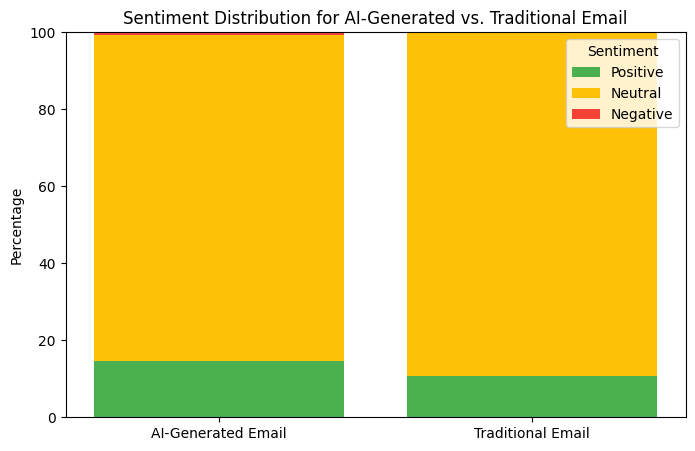

In [42]:
# Create the 100% stacked bar plot
fig, ax = plt.subplots(figsize=(8, 5))

bottoms = [0, 0]  # Track the bottom for each email type
colors = ['#4CAF50', '#FFC107', '#F44336']  # Colors for Positive, Neutral, Negative

for i in range(len(labels)):
    values = [d[i] for d in data]
    ax.bar(categories, values, bottom=bottoms, color=colors[i], label=labels[i])
    bottoms = [x + y for x, y in zip(bottoms, values)]  # Update bottoms for stacking

ax.set_title("Sentiment Distribution for AI-Generated vs. Traditional Email")
ax.set_ylabel("Percentage")
ax.legend(loc='upper right', title="Sentiment")
plt.show()

Observation:
- The neutral sentiment dominates both emails, occupying the largest portion of each bar. This suggests that both emails are largely factual or straightforward, without heavy emotional language
- The AI-generated email has a slightly larger positive segment than the traditional email, it could indicate that the AI-generated content uses a more positive tone to encourage engagement
- The lack of negative sentiment aligns with the goal of marketing emails to maintain a friendly and non-offensive tone

### Emotion Analysis

In [43]:
# Function to analyze emotions
def analyze_email_emotions_text2emotion(email_content):
    # Split content into sentences
    sentences = sent_tokenize(email_content)
    emotion_results = []
    
    for sentence in sentences:
        emotions = te.get_emotion(sentence)
        emotion_results.append({
            'sentence': sentence,
            'emotions': emotions
        })
        
        print(f"Sentence: {sentence}")
        print("Emotions:", emotions)
        print()
    return emotion_results

# Aggregate emotion scores
def aggregate_emotions_text2emotion(emotion_results):
    aggregate_emotions = {'Happy': 0, 'Angry': 0, 'Sad': 0, 'Surprise': 0, 'Fear': 0}
    for result in emotion_results:
        for emotion, score in result['emotions'].items():
            aggregate_emotions[emotion] += score
    
    total_score = sum(aggregate_emotions.values())
    for emotion in aggregate_emotions:
        aggregate_emotions[emotion] = (aggregate_emotions[emotion] / total_score) * 100 if total_score else 0
    
    return aggregate_emotions

In [44]:
# Perform emotion analysis on the AI-generated email
print("AI-Generated Email Sentence-by-Sentence Emotion Analysis:")
ai_sentence_emotions = analyze_email_emotions_text2emotion(ai_email_content)


AI-Generated Email Sentence-by-Sentence Emotion Analysis:
Sentence: Dear Customer 12583,

As a valued member of the Amazon family, we’re always looking for ways to make your shopping experience even better.
Emotions: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.67, 'Sad': 0.33, 'Fear': 0.0}

Sentence: Based on your recent interests, we’ve curated some product recommendations that we think you’ll love.
Emotions: {'Happy': 0.67, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.33, 'Fear': 0.0}

Sentence: Here’s what we’ve picked out for you:

1.
Emotions: {'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}

Sentence: **Havells Cista Room Heater, White, 2000 Watts**
   *Keep yourself warm and cozy this winter.
Emotions: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}

Sentence: *
   - Description: A room heater with a cool touch body and a one-year warranty.
Emotions: {'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.25, 'Fear': 0.5}

Sentence: It has two heat s

In [45]:
# Aggregate results for AI-generated email
ai_aggregated_emotions = aggregate_emotions_text2emotion(ai_sentence_emotions)

print("\nAI-Generated Email Aggregated Emotions:")
for emotion, score in ai_aggregated_emotions.items():
    print(f"{emotion}: {score:.2f}%")


AI-Generated Email Aggregated Emotions:
Happy: 13.00%
Angry: 3.86%
Sad: 20.76%
Surprise: 8.76%
Fear: 53.62%


In [46]:
# Perform emotion analysis on the Traditional email
print("\nTraditional Email Sentence-by-Sentence Emotion Analysis:")
traditional_sentence_emotions = analyze_email_emotions_text2emotion(traditional_email_content)


Traditional Email Sentence-by-Sentence Emotion Analysis:
Sentence: 
    New Recommendations Just for You!
Emotions: {'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}

Sentence: More to Explore
    Customers who have shown an interest in point-and-shoot cameras might like to see this week’s bestselling models:

    1.
Emotions: {'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.5}

Sentence: Canon PowerShot A495 10.0 MP Digital Camera
       - Features: 3.3x Optical Zoom, 2.5-Inch LCD
       - Learn More

    2.
Emotions: {'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}

Sentence: Canon PowerShot A3000IS 10 MP Digital Camera
       - Features: 4x Optical Image Stabilized Zoom, 2.7-Inch LCD
       - Learn More

    3.
Emotions: {'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}

Sentence: Canon PowerShot ELPH 300 HS 12 MP CMOS Digital Camera
       - Features: Full 1080p HD Video, Black
       - Learn More

    4.
Emotions: {'Happy': 0, 

In [47]:
# Aggregate results for Traditional email
traditional_aggregated_emotions = aggregate_emotions_text2emotion(traditional_sentence_emotions)

print("\nTraditional Email Aggregated Emotions:")
for emotion, score in traditional_aggregated_emotions.items():
    print(f"{emotion}: {score:.2f}%")


Traditional Email Aggregated Emotions:
Happy: 75.00%
Angry: 0.00%
Sad: 0.00%
Surprise: 0.00%
Fear: 25.00%


Observation:
It seems like the Text2Emotion analysis is misinterpreting some sentences, categorizing relatively neutral or factual descriptions (like the heater’s description) as evoking fear. This is likely because the algorithm is likely not context-aware and may associate certain keywords (e.g., "warranty" or "touch") with emotions like fear that are not intended in this context. This is likely due to the package utilising lexicon-based approaches, which may not fully understand the nuances of specific sentences